In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl, merge_intervals
from utils.colors import qual_cmap
from utils.stats import weighted_quantile

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import torch
import scipy.stats as ss
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict as ddict
from tqdm import tqdm, trange
import random
from joblib import Parallel, delayed
import pandas as pd
from pprint import pprint
plt.style.use(FIG_ROOT/"base.mplstyle")

In [5]:
pd.set_option('display.float_format', '{:.3f}'.format)

In [6]:
from collections import defaultdict as ddict
def fil_name2paras(fil_name):
    """plz be careful about 0.1 and 1
    """
    tmp = fil_name.split("_")
    paras = {}
    for itm in tmp:
        if '--' in itm:
            k, v = itm.split("--")
            v = f"0.{v}"
        elif '-' in itm:
            k, v = itm.split("-")
            # to be compatible with old simu
            if v.startswith("0"):
                v = f"0.{v}"
        else:
            continue
        
        if k.startswith("T"):
            k = "n_T"
        elif k.startswith("decay"):
            k = "weight_decay"
        elif k.startswith("infeat"):
            k = "n_infeat"
        paras[k] = float(v)
    paras["rep"] = int(tmp[1])
    return paras


In [7]:
# get results of DDIM and naive
def _add_res(res, key, dict_res):
    if key not in res.keys():
        return None
    dict_res["Len"].append(res[key][-1])
    dict_res["ITE"].append(res[key][0])
    dict_res["method"].append(key)
    for ky, v in cur_paras.items():
        dict_res[ky].append(v)
        
setting = "setting2"
#setting = "setting4"
d = 10
res_dir = RES_ROOT/f"simu_real_data_naive"
#res_dir = RES_ROOT/f"simu_{setting}_d{d}_n3000"
all_fils = list(res_dir.glob("*n_T-*.pkl"));
our_res = ddict(list)
for fil in all_fils:
    cur_paras = fil_name2paras(fil.stem);
    res = load_pkl(fil, verbose=False);
    
    _add_res(res, key="DDIM", dict_res=our_res)
    _add_res(res, key="DDIM_val", dict_res=our_res)
    _add_res(res, key="naive", dict_res=our_res)
    _add_res(res, key="naive_val", dict_res=our_res)
    
    for model_ix in range(500, 6000, 500):
        _add_res(res, key=f"DDIM_ep{model_ix}", dict_res=our_res)
        _add_res(res, key=f"DDIM_ep{model_ix}_val", dict_res=our_res)
        _add_res(res, key=f"naive_ep{model_ix}", dict_res=our_res)
        _add_res(res, key=f"naive_ep{model_ix}_val",dict_res=our_res)
        
our_res_df = pd.DataFrame(our_res);

In [8]:
# results of CQR and CF
def _add_ores(res, key, dict_res):
    if key not in res.keys():
        return None
    dict_res["Len"].append(res[key][-1])
    dict_res["ITE"].append(res[key][0])
    dict_res["method"].append(key)
    dict_res["rep"].append(_get_rep(ofil))
_get_rep = lambda p: int(p.stem.split("_")[1])
ofils = list(res_dir.glob("*other*.pkl"));
other_res = ddict(list);
for ofil in ofils:
    res = load_pkl(ofil, verbose=False);
    _add_ores(res, key="CQR", dict_res=other_res)
    _add_ores(res, key="CF", dict_res=other_res)
other_res_df = pd.DataFrame(other_res);

In [9]:
# check all hyper-param combos
grp_var = ["n_T", "lr", "n_infeat", "upblk",  "downblk", "weight_decay"]
our_res_df[our_res_df["method"] == "DDIM"].groupby(grp_var)[["ITE"]].agg(["count"])

ITE
                                                  count
n_T     lr    n_infeat upblk downblk weight_decay      
100.000 0.010 128.000  1.000 1.000   0.010          100
                       3.000 3.000   0.010          100
              256.000  1.000 1.000   0.010          100
                       3.000 3.000   0.010          100
        0.100 128.000  1.000 1.000   0.010          100
                       3.000 3.000   0.010          100
              256.000  1.000 1.000   0.010          100
                       3.000 3.000   0.010          100
200.000 0.010 128.000  1.000 1.000   0.010          100
                       3.000 3.000   0.010          100
              256.000  1.000 1.000   0.010          100
                       3.000 3.000   0.010          100
        0.100 128.000  1.000 1.000   0.010          100
                       3.000 3.000   0.010          100
              256.000  1.000 1.000   0.010          100
                       3.000 3.000   0.010          100
400.000 0.010 128.000  1.000 1.000   0.010          100
                       3.000 3.000   0.010          100
              256.000  1.000 1.000   0.010          100
                       3.000 3.000   0.010          100
        0.100 128.000  1.000 1.000   0.010          100
                       3.000 3.000   0.010          100
              256.000  1.000 1.000   0.010          100
                       3.000 3.000   0.010          100

# Select com for each rep

In [25]:
# get opt obs based on val set
def _get_opt_obs_given_repix(rep_ix, all_res_df, method_key="DDPM", cutoff=None):
    cols = ["method", "lr", "n_infeat", "n_T", "weight_decay", "upblk", "downblk", "rep"]
    kpidx = np.bitwise_and(all_res_df["rep"] == rep_ix, all_res_df["method"].map(lambda x: ("val" in x) and (method_key in x)));
    if cutoff is not None:
        kpidx = np.bitwise_and(kpidx, all_res_df["ITE"]>cutoff)
    if kpidx.sum() == 0:
        kpidx = np.bitwise_and(all_res_df["rep"] == rep_ix, all_res_df["method"].map(lambda x: ("val" in x) and (method_key in x)))
    
    best_val = all_res_df[kpidx].sort_values(by="Len").iloc[0]
    mask = np.ones(all_res_df.shape[0], dtype=bool)
    for col in cols:
        if col.startswith("method"):
            #v = best_val[col]
            v = best_val[col].split("_val")[0]
            mask = np.bitwise_and(mask, all_res_df[col].isin([v]))
            
        else: 
            v = best_val[col]
            mask = np.bitwise_and(mask, all_res_df[col] == v)
    return all_res_df[mask]

In [26]:
our_res_df1 = our_res_df#[our_res_df['n_T']==400]
best_res = []
cutoff = 0.95
for cur_rep in list(set(our_res_df1["rep"])):
    best_res.append(_get_opt_obs_given_repix(cur_rep, our_res_df1, "naive", cutoff))
    best_res.append(_get_opt_obs_given_repix(cur_rep, our_res_df1, "DDIM", cutoff))
    
best_res = pd.concat(best_res);
best_res1 = best_res.copy();
best_res["method"] = best_res["method"].map(lambda x: x.split("_")[0])
best_res = best_res[["Len", "ITE", "method", "rep"]];

In [27]:
# put the results together
all_res_df = pd.concat([best_res, other_res_df])
all_res_df.groupby(["method"])[["Len", "ITE"]].agg(["mean", "median", "std", "count"])

Len                       ITE                   
         mean median    std count  mean median   std count
method                                                    
CF      2.978  1.488  4.206   100 0.275  0.280 0.075   100
CQR    13.405  7.226 16.617   100 0.956  0.960 0.029   100
DDIM    9.317  5.260 22.732   100 0.943  0.947 0.028   100
naive   2.481  0.423  4.646   100 0.297  0.147 0.306   100

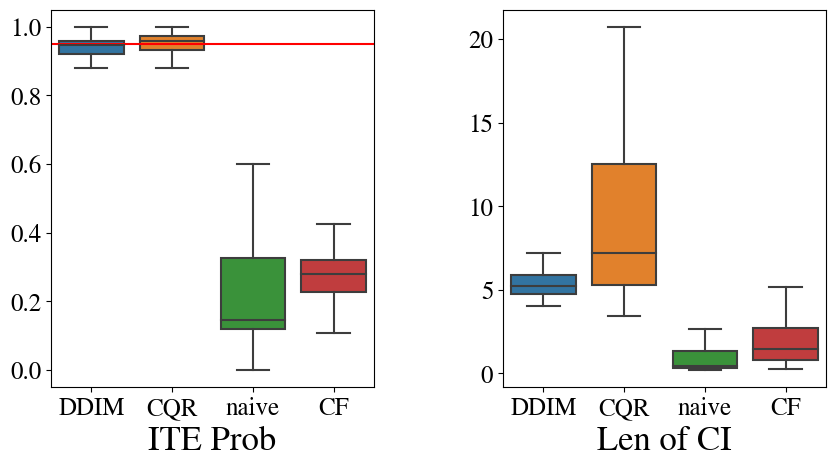

In [28]:
method_order=["DDIM", "CQR", "naive", "CF"]
plt.subplot(121)
sns.boxplot(data=all_res_df, y="ITE", x="method", showfliers=False, order=method_order, orient='v')
plt.axhline(y=0.95, color="red");
plt.ylabel("")
plt.xlabel("ITE Prob")
plt.subplot(122)
sns.boxplot(data=all_res_df, y="Len", x="method", showfliers=False, order=method_order, orient='v')
plt.ylabel("")
plt.xlabel("Len of CI");

# Select com by mean

(400.0, 0.01, 256.0, 3.0, 3.0, 0.01, 'DDIM') (400.0, 0.01, 256.0, 3.0, 3.0, 0.01, 'DDIM')


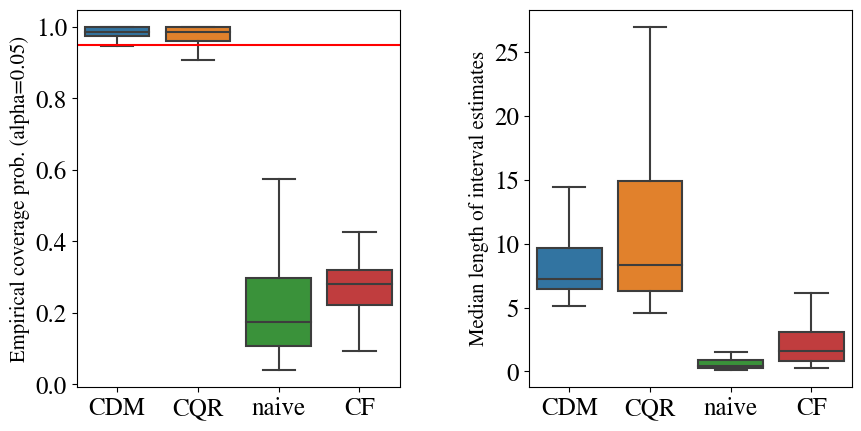

In [19]:
# naive results/results with a specific hyper params
# get sorted idx
grp_var1 = ["n_T", "lr", "n_infeat", "upblk",  "downblk", "weight_decay", "method"]
if our_res_df["method"].map(lambda x: "val" in x).sum() == 0:
    sorted_idx = (our_res_df[our_res_df["method"]
                .map(lambda x: "DDIM" in x)]
                .groupby(grp_var1)[["Len"]]
                .agg(["median", "mean"])[("Len", "mean")]
                .sort_values().index)
    ddim_idx = sorted_idx[0]
    ddim_idx_raw = sorted_idx[0]
else:
    sorted_idx = (our_res_df[our_res_df["method"]
                .map(lambda x: "DDIM" in x and "val" in x)]
                .groupby(grp_var1)[["Len"]]
                .agg(["median", "mean"])[("Len", "mean")]
                .sort_values().index)
    ddim_idx_raw = sorted_idx[0]
    ddim_idx = list(ddim_idx_raw)
    ddim_idx[-1] = ddim_idx[-1].split("_val")[0]
    ddim_idx = tuple(ddim_idx)

our_res_grp = our_res_df.groupby(grp_var1)[["method", "ITE", "Len", "rep"]]
print(ddim_idx, ddim_idx_raw)
naive_idx = list(ddim_idx)
naive_idx[-1] = naive_idx[-1].replace("DDIM", "naive")
naive_idx = tuple(naive_idx)
df1 = our_res_grp.get_group(ddim_idx)
df2 = our_res_grp.get_group(naive_idx)
res_one = pd.concat([df1, df2, other_res_df])
res_one["method"] = res_one["method"].map(lambda x: x.split("_ep")[0])
res_one.groupby(["method"])[["Len", "ITE"]].agg(["mean", "median", "std", "count", "max"])

my_method = "CDM" 
res_one["method"] = res_one["method"].map(lambda x: my_method if x == "DDIM" else x)

method_order=[my_method, "CQR", "naive", "CF"]
plt.figure(figsize=[10, 5])
plt.subplot(121)
sns.boxplot(data=res_one, y="ITE", x="method", showfliers=False, order=method_order, orient='v')
plt.axhline(y=0.95, color="red");
plt.ylabel("Empirical coverage prob. (alpha=0.05)", fontsize=15)
plt.xlabel("");
plt.subplot(122)
sns.boxplot(data=res_one, y="Len", x="method", showfliers=False, order=method_order, orient='v')
plt.ylabel("Median length of interval estimates", fontsize=15)
plt.xlabel("");
plt.savefig(FIG_ROOT/f"real_data_naive_way.jpg")

In [21]:
res_df = our_res_df[our_res_df["method"].map(lambda x: "naive" not in x)].groupby(["n_infeat", "upblk", 
                             "downblk", "weight_decay", 
                             "lr", "n_T",   "method"])[["Len", "ITE"]].agg(["mean", "median", "std", "count"]);

val_df = res_df[res_df.index.map(lambda x: "val" in x[-1])]
#val_df = val_df[val_df[("ITE", "median")] > 0.95].reindex()



sorted_val_idx = val_df[("Len", "median")].sort_values().index
sorted_test_idx = pd.MultiIndex.from_tuples([tuple(list(ix[:-1])+[ix[-1].split("_val")[0]]) for ix in sorted_val_idx], 
                                            names=sorted_val_idx.names);

res_df.loc[sorted_test_idx].head(n=30)

Len  \
                                                                                               mean   
n_infeat upblk downblk weight_decay lr    n_T     method                                              
256.000  3.000 3.000   0.010        0.010 100.000 DDIM_ep1500                   632777531719680.000   
                                                  DDIM_ep1000                  1842893962608640.000   
                                                  DDIM_ep500                                 79.083   
                                                  DDIM_ep2000           35827817130193118560256.000   
                                                  DDIM_ep3000                                14.578   
                                                  DDIM_ep3500                                15.293   
                                                  DDIM                                       15.217   
         1.000 1.000   0.010        0.010 100.000 DDIM_ep1500         5291635887288083493683200.000   
                                                  DDIM_ep1000                    52379722448896.000   
                                                  DDIM_ep500                             123312.320   
         3.000 3.000   0.010        0.010 100.000 DDIM_ep2500          154207484624815511306240.000   
         1.000 1.000   0.010        0.010 100.000 DDIM              440568200398423648632832000.000   
128.000  1.000 1.000   0.010        0.100 200.000 DDIM_ep500                                 36.271   
         3.000 3.000   0.010        0.010 100.000 DDIM_ep3500   1264466138503637016421880299520.000   
         1.000 1.000   0.010        0.100 200.000 DDIM_ep1000                                35.618   
256.000  1.000 1.000   0.010        0.010 100.000 DDIM_ep3500     55636697666556728304870621184.000   
128.000  1.000 1.000   0.010        0.010 100.000 DDIM        567584714722629336631976679964672.000   
                                                  DDIM_ep500                              11008.156   
                                                  DDIM_ep3500 102543467185725848188793670074368.000   
         3.000 3.000   0.010        0.010 100.000 DDIM_ep500                                108.513   
256.000  1.000 1.000   0.010        0.010 100.000 DDIM_ep3000        34791912852862622786125824.000   
                                                  DDIM_ep2500            2067360379708335194112.000   
128.000  1.000 1.000   0.010        0.100 200.000 DDIM_ep3500       205017371889624988593946624.000   
256.000  1.000 1.000   0.010        0.010 100.000 DDIM_ep2000        56197420136431808719880192.000   
128.000  3.000 3.000   0.010        0.010 100.000 DDIM         18081571029375614543057230233600.000   
                                                  DDIM_ep3000  15583904898609578760901601787904.000   
         1.000 1.000   0.010        0.100 200.000 DDIM                                       32.249   
                                    0.010 100.000 DDIM_ep3000      4603019000191796208268738560.000   
256.000  1.000 1.000   0.010        0.100 200.000 DDIM_ep500                                 34.714   
128.000  1.000 1.000   0.010        0.100 100.000 DDIM                        97787377308663808.000   

                                                                      \
                                                              median   
n_infeat upblk downblk weight_decay lr    n_T     method               
256.000  3.000 3.000   0.010        0.010 100.000 DDIM_ep1500  6.828   
                                                  DDIM_ep1000  7.368   
                                                  DDIM_ep500   7.835   
                                                  DDIM_ep2000 11.787   
                                                  DDIM_ep3000 13.968   
                                                  DDIM_ep3500 14.673   
                                                

In [18]:
res_df.loc[sorted_test_idx].head(n=10)

Len         \
                                                                mean median   
n_infeat upblk downblk weight_decay lr    n_T     method                      
128.000  1.000 1.000   0.010        0.010 100.000 DDIM_ep500  80.749 66.238   
         3.000 3.000   0.010        0.100 100.000 DDIM_ep500  81.606 67.498   
         5.000 5.000   0.010        0.100 100.000 DDIM_ep500  80.868 67.961   
                                                  DDIM_ep1000 81.631 69.132   
256.000  3.000 3.000   0.010        0.100 100.000 DDIM_ep500  80.142 69.724   
128.000  3.000 3.000   0.010        0.100 100.000 DDIM_ep1000 84.396 70.716   
         5.000 5.000   0.010        0.100 100.000 DDIM_ep1500 87.665 72.072   
                                                  DDIM_ep4000 84.316 72.496   
         3.000 3.000   0.010        0.100 100.000 DDIM_ep5500 88.626 73.803   
         5.000 5.000   0.010        0.100 100.000 DDIM_ep3500 88.011 72.490   

                                                                            \
                                                                 std count   
n_infeat upblk downblk weight_decay lr    n_T     method                     
128.000  1.000 1.000   0.010        0.010 100.000 DDIM_ep500  40.252    42   
         3.000 3.000   0.010        0.100 100.000 DDIM_ep500  49.090   100   
         5.000 5.000   0.010        0.100 100.000 DDIM_ep500  48.774   100   
                                                  DDIM_ep1000 47.844   100   
256.000  3.000 3.000   0.010        0.100 100.000 DDIM_ep500  40.115    48   
128.000  3.000 3.000   0.010        0.100 100.000 DDIM_ep1000 50.044   100   
         5.000 5.000   0.010        0.100 100.000 DDIM_ep1500 56.299   100   
                                                  DDIM_ep4000 47.891   100   
         3.000 3.000   0.010        0.100 100.000 DDIM_ep5500 80.765    99   
         5.000 5.000   0.010        0.100 100.000 DDIM_ep3500 61.538   100   

                                                                ITE         \
                                                               mean median   
n_infeat upblk downblk weight_decay lr    n_T     method                     
128.000  1.000 1.000   0.010        0.010 100.000 DDIM_ep500  0.953  0.957   
         3.000 3.000   0.010        0.100 100.000 DDIM_ep500  0.953  0.954   
         5.000 5.000   0.010        0.100 100.000 DDIM_ep500  0.953  0.955   
                                                  DDIM_ep1000 0.953  0.952   
256.000  3.000 3.000   0.010        0.100 100.000 DDIM_ep500  0.952  0.952   
128.000  3.000 3.000   0.010        0.100 100.000 DDIM_ep1000 0.954  0.957   
         5.000 5.000   0.010        0.100 100.000 DDIM_ep1500 0.953  0.953   
                                                  DDIM_ep4000 0.953  0.953   
         3.000 3.000   0.010        0.100 100.000 DDIM_ep5500 0.943  0.955   
         5.000 5.000   0.010        0.100 100.000 DDIM_ep3500 0.954  0.955   

                                                                           
                                                                std count  
n_infeat upblk downblk weight_decay lr    n_T     method                   
128.000  1.000 1.000   0.010        0.010 100.000 DDIM_ep500  0.016    42  
         3.000 3.000   0.010        0.100 100.000 DDIM_ep500  0.014   100  
         5.000 5.000   0.010        0.100 100.000 DDIM_ep500  0.013   100  
                                                  DDIM_ep1000 0.013   100  
256.000  3.000 3.000   0.010        0.100 100.000 DDIM_ep500  0.014    48  
128.000  3.000 3.000   0.010        0.100 100.000 DDIM_ep1000 0.014   100  
         5.000 5.000   0.010        0.100 100.000 DDIM_ep1500 0.014   100  
                                                  DDIM_ep4000 0.012   100  
         3.000 3.000   0.010        0.100 100.000 DDIM_ep5500 0.097   100  
         5.000 5.000   0.010        0.100 100.000 DDIM_ep3500 0.012   100

In [19]:
res_df.loc[sorted_val_idx].head(n=10)

Len  \
                                                                    mean   
n_infeat upblk downblk weight_decay lr    n_T     method                   
128.000  1.000 1.000   0.010        0.010 100.000 DDIM_ep500_val  80.596   
         3.000 3.000   0.010        0.100 100.000 DDIM_ep500_val  81.481   
         5.000 5.000   0.010        0.100 100.000 DDIM_ep500_val  80.807   
                                                  DDIM_ep1000_val 81.523   
256.000  3.000 3.000   0.010        0.100 100.000 DDIM_ep500_val  80.010   
128.000  3.000 3.000   0.010        0.100 100.000 DDIM_ep1000_val 84.601   
         5.000 5.000   0.010        0.100 100.000 DDIM_ep1500_val 87.485   
                                                  DDIM_ep4000_val 84.197   
         3.000 3.000   0.010        0.100 100.000 DDIM_ep5500_val 87.338   
         5.000 5.000   0.010        0.100 100.000 DDIM_ep3500_val 87.807   

                                                                          \
                                                                  median   
n_infeat upblk downblk weight_decay lr    n_T     method                   
128.000  1.000 1.000   0.010        0.010 100.000 DDIM_ep500_val  66.150   
         3.000 3.000   0.010        0.100 100.000 DDIM_ep500_val  67.407   
         5.000 5.000   0.010        0.100 100.000 DDIM_ep500_val  67.947   
                                                  DDIM_ep1000_val 69.058   
256.000  3.000 3.000   0.010        0.100 100.000 DDIM_ep500_val  69.680   
128.000  3.000 3.000   0.010        0.100 100.000 DDIM_ep1000_val 70.927   
         5.000 5.000   0.010        0.100 100.000 DDIM_ep1500_val 71.829   
                                                  DDIM_ep4000_val 72.037   
         3.000 3.000   0.010        0.100 100.000 DDIM_ep5500_val 72.181   
         5.000 5.000   0.010        0.100 100.000 DDIM_ep3500_val 72.361   

                                                                          \
                                                                     std   
n_infeat upblk downblk weight_decay lr    n_T     method                   
128.000  1.000 1.000   0.010        0.010 100.000 DDIM_ep500_val  40.185   
         3.000 3.000   0.010        0.100 100.000 DDIM_ep500_val  49.061   
         5.000 5.000   0.010        0.100 100.000 DDIM_ep500_val  48.791   
                                                  DDIM_ep1000_val 47.837   
256.000  3.000 3.000   0.010        0.100 100.000 DDIM_ep500_val  40.060   
128.000  3.000 3.000   0.010        0.100 100.000 DDIM_ep1000_val 50.913   
         5.000 5.000   0.010        0.100 100.000 DDIM_ep1500_val 56.056   
                                                  DDIM_ep4000_val 47.873   
         3.000 3.000   0.010        0.100 100.000 DDIM_ep5500_val 73.468   
         5.000 5.000   0.010        0.100 100.000 DDIM_ep3500_val 61.008   

                                                                          ITE  \
                                                                  count  mean   
n_infeat upblk downblk weight_decay lr    n_T     method                        
128.000  1.000 1.000   0.010        0.010 100.000 DDIM_ep500_val     42 0.950   
         3.000 3.000   0.010        0.100 100.000 DDIM_ep500_val    100 0.949   
         5.000 5.000   0.010        0.100 100.000 DDIM_ep500_val    100 0.950   
                                                  DDIM_ep1000_val   100 0.949   
256.000  3.000 3.000   0.010        0.100 100.000 DDIM_ep500_val     48 0.951   
128.000  3.000 3.000   0.010        0.100 100.000 DDIM_ep1000_val   100 0.949   
         5.000 5.000   0.010        0.100 100.000 DDIM_ep1500_val   100 0.950   
                                                  DDIM_ep4000_val   100 0.949   
         3.000 3.000   0.010        0.100 100.000 DDIM_ep5500_val    99 0.939   
         5.000 5.000   0.010        0.100 100.000 DDIM_ep3500_val   100 0.950   

                                                

In [26]:
kpidx = our_res_df["method"].map(lambda x: "naive" not in x)
kpidx = np.bitwise_and(kpidx, our_res_df["n_infeat"]==256)
kpidx = np.bitwise_and(kpidx, our_res_df["n_T"]==100)
kpidx = np.bitwise_and(kpidx, our_res_df["method"]=="DDIM_ep1000")
kpidx = np.bitwise_and(kpidx, our_res_df["lr"]==0.1)
kpidx = np.bitwise_and(kpidx, our_res_df["upblk"]==1)
our_res_df[kpidx].groupby(["n_infeat", "upblk", 
                             "downblk", "weight_decay", 
                             "lr", "n_T",   "method"])[["Len", "ITE"]].agg(["mean", "median", "std", "count"])

Len         \
                                                               mean median   
n_infeat upblk downblk weight_decay lr    n_T     method                     
256.000  1.000 1.000   0.010        0.100 100.000 DDIM_ep1000 5.819  5.506   

                                                                           \
                                                                std count   
n_infeat upblk downblk weight_decay lr    n_T     method                    
256.000  1.000 1.000   0.010        0.100 100.000 DDIM_ep1000 1.153    50   

                                                                ITE         \
                                                               mean median   
n_infeat upblk downblk weight_decay lr    n_T     method                     
256.000  1.000 1.000   0.010        0.100 100.000 DDIM_ep1000 0.943  0.941   

                                                                           
                                                                std count  
n_infeat upblk downblk weight_decay lr    n_T     method                   
256.000  1.000 1.000   0.010        0.100 100.000 DDIM_ep1000 0.017    50